In [1]:
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [4]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF
import seaborn as sns
import polars as pl
import numpy as np

from case_edits.ezcase import *
from helpers.helpers import *
from helpers.variables import *
from helpers.variable_interfaces import *
from setup.setup import *
from setup.plots import *
from setup.data_wrangle import *
from analysis.data_on_network import *

import matplotlib.cm as cm
import matplotlib as mpl


from matplotlib.colors import Colormap, Normalize, LinearSegmentedColormap
from setup.setup import create_directories

from helpers.ep_helpers import *
from subsurfaces.creator import SubsurfaceCreator
from airflow_network.airboundary import *
from subsurfaces.logic import find_surface_connecting_two_zones
from analysis.analysis import *


In [8]:
# create_cases(AIRBOUNDARY_FOLDER)

In [9]:
cases = retrieve_cases(AIRBOUNDARY_FOLDER)
sc = cases[0]
sc

CaseData(case_name='amb_b1', idf=<geomeppy.idf.IDF object at 0x137ba35e0>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/airboundary/case_amb_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_amb_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/airboundary/case_amb_b1'))

In [19]:
df_vol = create_zone_vol_df_many(cases)
df_vol.head()

case_names,space_names,datetimes,qoi,values,qoi_0,values_0,qoi_1,values_1
str,str,datetime[μs],str,f64,str,f64,str,f64
"""amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:00:00,"""AFN Zone Ventilation Volume""",143.226488,"""AFN Zone Mixing Volume""",49.152433,"""Zone Mean Air Temperature""",20.294237
"""amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:15:00,"""AFN Zone Ventilation Volume""",136.286629,"""AFN Zone Mixing Volume""",78.498555,"""Zone Mean Air Temperature""",19.65716
"""amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:30:00,"""AFN Zone Ventilation Volume""",134.326382,"""AFN Zone Mixing Volume""",99.799424,"""Zone Mean Air Temperature""",19.062418
"""amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:45:00,"""AFN Zone Ventilation Volume""",133.998411,"""AFN Zone Mixing Volume""",125.081848,"""Zone Mean Air Temperature""",18.506943
"""amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 01:00:00,"""AFN Zone Ventilation Volume""",124.186284,"""AFN Zone Mixing Volume""",116.310663,"""Zone Mean Air Temperature""",18.200911


Text(0.5, 0, 'AFN Zone Ventilation Volume [m3]')

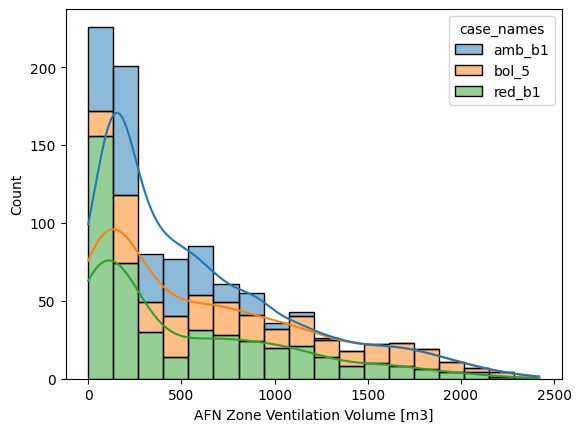

In [34]:
# vent - no 0s 
values = "values"
qoi = "qoi"
df_filter = df_vol.filter(pl.col(values) > 0)
g = sns.histplot(df_filter, x=values,  hue="case_names", kde=True, multiple="stack", fill=True)

_, qoi_info = get_plot_labels(sc, df_vol[qoi][0])
g.set_xlabel(qoi_info)

Text(0.5, 0, 'AFN Zone Mixing Volume [m3]')

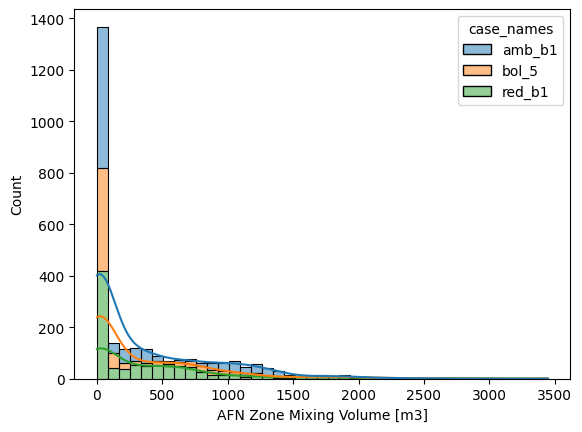

In [35]:
values = "values_0"
qoi = "qoi_0"
df_filter = df_vol.filter(pl.col(values) > 0)
g = sns.histplot(df_vol, x=values,  hue="case_names", kde=True, multiple="stack")

_, qoi_info = get_plot_labels(sc, df_vol[qoi][0])
g.set_xlabel(qoi_info)

In [ ]:

sns.displot(penguins, x="flipper_length_mm", hue="species", kind="ecdf")